In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy import linalg
#from numpy import *
import pandas as pd
%matplotlib inline

# Introduction
The Hamiltonian for this system is 
$$
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$$

$$
H = \frac{J}{2}\sigma_x^{(d)}\sigma_x^{(a)}+\frac{\Delta}{2}\sigma_z^{(d)}+\frac{\kappa}{2}\sigma_z^{(d)}(\hat{a}+\hat{a}^{\dagger})+\nu_{eff}\hat{a}^{\dagger}\hat{a}
$$
where $J = \eta_{ax}^2 \Omega_1 \Omega_2 / \delta_{ms}$ is the coupling coefficient, $\eta_{ax}$ is the Lamb-Dekie parameter for axial axis, $\Omega_{1,2}$ are Rabi frequencies. It can be measured by setting $\Delta, \kappa = 0$.
<br>
$\Delta$: Relative energy detuning. AC-Stark shift caused by the energy imbalance of two tones of local beam.
<br>
$\kappa$ is the coupling coeeficient between environment and sites, $\kappa = \eta_{r}^2 \Omega^L_1 \Omega^L_2 / \omega_r$, where $\Omega^L_i$ is the on-resonance coupling between $\ket{S}$ and $\ket{D}$ states generated by the ith tone of the local beam.

In [118]:
class VAET:
    def __init__(self, 
                 Nmax = 20, # max number of phonons
                 J = 1,     # kHz
                 Delta = 1, # kHz
                 kappa = 1, # kHz
                 nu = 1    # kHz     
                ):
        self.Nmax = Nmax
        self.J = J * 2 * np.pi
        self.Delta = Delta * 2 * np.pi
        self.kappa = kappa * 2 * np.pi
        self.nu = nu * 2 * np.pi
        
        self.nth = 0
        self.s_init = tensor(\
                             ket2dm(tensor(basis(2, 0), basis(2, 1))), thermal_dm(self.Nmax, 0.5))
        self.output = None
        
    def solve(self, tlist):
        a = create(self.Nmax) # basis(2,0) is excited state
        
        H0 = self.J/2 * tensor(sigmax(), sigmax(), qeye(self.Nmax))
        H1 = -self.Delta/2 * tensor(sigmaz(),qeye(2),qeye(self.Nmax)) # since ground state is basis(2,1)
        H2 = -self.kappa/2 * tensor(sigmaz(),qeye(2),(a + a.dag()))
        H3 = self.nu * tensor(qeye(2),qeye(2),a.dag()*a)
        
        H = H0 + H1 + H2 + H3
        
        c_ops = []

        self.output = mesolve(H, self.s_init, tlist, c_ops, [])
    
    def time_scan(self,
                  t_start,
                  t_stop,
                  Nsample,
                  nth = 0.5,
                  which = 1
                 ):
        self.nth = nth
        self.s_init = tensor(\
                    ket2dm(tensor(basis(2, 0), basis(2, 1))), thermal_dm(self.Nmax, self.nth))
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)
        now2 = datetime.datetime.now()
        print('time elapsed:', now2-now)
        states = self.output.states
        #self.measure(states, self.output.times, 0)
        self.measure(states, self.output.times, 1)
        #self.jointMeasure(states, self.output.times)
        
    def measure(self, states, x_axis, which):
        # states: np.array of dm includes two ions and phonons
        # which: donor 0, acceptor: 1
        s_g = basis(2, 1) # basis(2,1) is ground state
        s_e = basis(2, 0) # basis(2,0) is excited state
        
        def _measure(state, s_meas, which):
            state_ptr = state.ptrace(which)  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        e = np.zeros(len(states))
        g = np.zeros(len(states))
        for i in range(len(states)):
            e[i] = _measure(states[i], s_e, which)
            g[i] = _measure(states[i], s_g, which)
            
        fig, ax = plt.subplots()
        ax.plot(x_axis, e)
        ax.set_xlabel('Time (ms)')
        if which == 0:
            ax.set_ylabel('Probability of excited state of Donor')
        elif which == 1:
            ax.set_ylabel('Probability of excited state of Acceptor')
        plt.ylim(0,1)
        #ax.legend(('Ground state', 'Excited state'))
        plt.show()    

    def jointMeasure(self, states, x_axis):
        # states: np.array of dm includes two ions and phonons
        s_ee = tensor(basis(2, 0), basis(2, 0))
        s_gg = tensor(basis(2, 1), basis(2, 1))
        s_eg = tensor(basis(2, 0), basis(2, 1))
        s_ge = tensor(basis(2, 1), basis(2, 0))
        
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        ee = np.zeros(len(states))
        gg = np.zeros(len(states))
        eg = np.zeros(len(states))
        ge = np.zeros(len(states))
        for i in range(len(states)):
            ee[i] = _measure(states[i], s_ee)
            gg[i] = _measure(states[i], s_gg)
            eg[i] = _measure(states[i], s_eg)
            ge[i] = _measure(states[i], s_ge)
        P_acc = ge/(ge+eg)
        fig, ax = plt.subplots()
        ax.plot(x_axis, P_acc)
        ax.plot(x_axis, eg)
        ax.plot(x_axis, ge)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('$P_{acc}$')
        ax.legend(('$P_{acc}$','eg', 'ge'))
        plt.show()
        
    def PaccVsVeff(self,
                   nu_start,
                   nu_stop,
                   Nusample,
                   t_start,
                   t_stop,
                   Nsample,
                   Delta,
                   nth = 0.5
                  ):
        now = datetime.datetime.now()
        def _ptrmeasure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
        def _measure(state, s_meas):
            state_ptr = state.ptrace(1)  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
        P_peak = []
        
        nus = np.linspace(nu_start, nu_stop, Nusample)
        for nu in nus:
            self.nth = nth
            self.nu = nu * 2 * np.pi
            self.Delta = Delta * 2 * np.pi
            self.s_init = tensor(\
                        ket2dm(tensor(basis(2, 0), basis(2, 1))), thermal_dm(self.Nmax, self.nth))
            t_list = np.linspace(t_start, t_stop, Nsample)
            self.solve(t_list)
            states = self.output.states
            # states: np.array of dm includes two ions and phonons
            s_eg = tensor(basis(2, 0), basis(2, 1))
            s_ge = tensor(basis(2, 1), basis(2, 0))
            s_e = basis(2, 0)
            eg = np.zeros(len(states))
            ge = np.zeros(len(states))
            e = np.zeros(len(states))
            for i in range(len(states)):
                #eg[i] = _ptrmeasure(states[i], s_eg)
                #ge[i] = _ptrmeasure(states[i], s_ge)
                e[i] = _measure(states[i], s_e)
            #P_acc = ge/(ge+eg)
            plt.plot(t_list, e)
            #P_peak.append(P_acc[-1])
            #P_peak.append(max(P_acc))
            P_peak.append(max(e))
        '''fig, ax = plt.subplots()
        ax.plot(nus, P_peak)
        ax.set_xlabel('$v_{eff}/2\pi$')
        ax.set_ylabel('$P_{acc}$')
        #ax.legend(('$P_{acc}$','eg', 'ge'))
        plt.show()'''
        now2 = datetime.datetime.now()
        print('time elapsed:', now2-now)
        return P_peak
        
    def ScanPaccVsVeff(self,
                       Navg,
                       noise,
                       nu_start,
                       nu_stop,
                       Nusample,
                       t_start,
                       t_stop,
                       Nsample,
                       Delta,
                       nth
                      ):
        def _average(lst):
            nrows = len(lst)
            ncols = len(lst[0])
            nelem = float(nrows)
            results = ncols*[0] # avgs per column
            for col in range(ncols):
                for row in range(nrows):
                    results[col] += lst[row][col]
                results[col] /= nelem
            return results  
        P_sum = []
        Delta_mean = Delta
        
        nus = np.linspace(nu_start, nu_stop, Nusample)
        for i in range(Navg):
            Delta_new = Delta_mean*(1+np.random.normal(0, noise))
            P_sum.append(self.PaccVsVeff(nu_start = nu_start,
                                    nu_stop = nu_stop,
                                    Nusample = Nusample,
                                    t_start = t_start,
                                    t_stop = t_stop,
                                    Nsample = Nsample,
                                    Delta = Delta_new,
                                    nth = nth))
            #plt.plot(nus,P_sum[i])
        P_avg = _average(P_sum)
        fig, ax = plt.subplots()
        ax.plot(nus, P_avg)
        ax.set_xlabel('$v_{eff}/2\pi$')
        ax.set_ylabel('$P_{acc}$')
        #ax.legend(('$P_{acc}$','eg', 'ge'))
        plt.show()

time elapsed: 0:00:00.082005


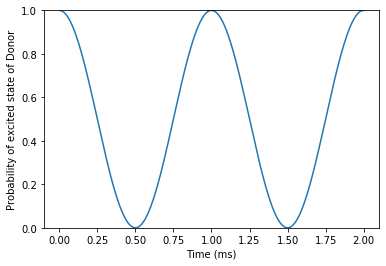

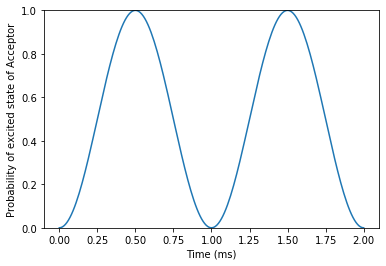

In [89]:
exp1 = VAET(Nmax=20, J = 1, Delta = 0, kappa = 0, nu = 0)
exp1.time_scan(0, 2, 200, nth = 0, which = 1)

In absence of energy barrier $\Delta$, and without the presence of an environment ($\kappa = 0$)

time elapsed: 0:00:00.111412


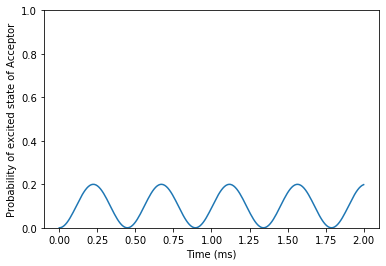

In [119]:
exp2 = VAET(Nmax=20, J =1, Delta = 2, kappa = 0, nu = 0)
exp2.time_scan(0, 2, 200, nth = 0, which = 1)
#exp2.time_scan(0, 2, 200, nth = 0, which = 0)

In presence of energy barrier $\Delta$, but without the presence of an environment ($\kappa = 0$). The amplitude of excited state is attenuated

time elapsed: 0:00:00.755224


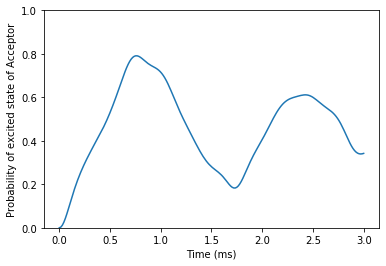

In [120]:
exp3 = VAET(Nmax=20, J = 1.17, Delta = 1.59, kappa = 0.63, nu = -1.72)
exp3.time_scan(0, 3, 200, nth = 12, which = 1)

## Findings
### Finding 1. 
(a) Significant tesfer occurs only at $\nu_{eff} = \sqrt{\Delta^2+J^2}/k$, which corresponds to $\ket{SD,n} \Rightarrow \ket{DS, n\pm k}$
<br>
(b) For sufficient large $\Delta$, the multiphonon process can be spectrally resolved up to a maximum integer value. However, when J ~ $\Delta$, the multiphonon, single-phonon, inter-site process will not be distinguishable.

k =  1.0
time elapsed: 0:00:37.534251


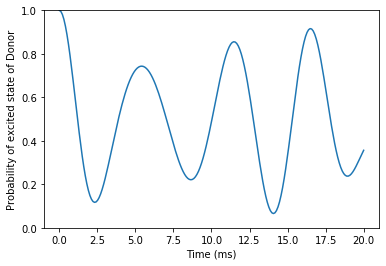

k =  1.25
time elapsed: 0:00:33.067118


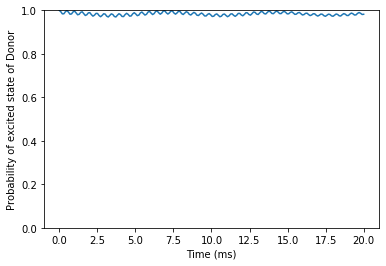

k =  1.5
time elapsed: 0:00:43.671772


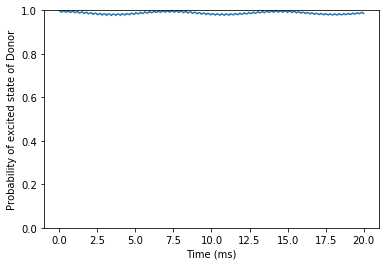

k =  1.75
time elapsed: 0:00:22.667225


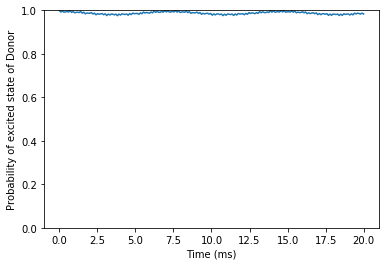

k =  2.0
time elapsed: 0:00:26.756052


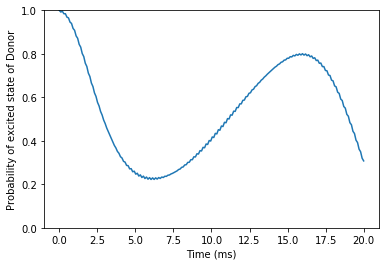

k =  2.25
time elapsed: 0:00:29.676265


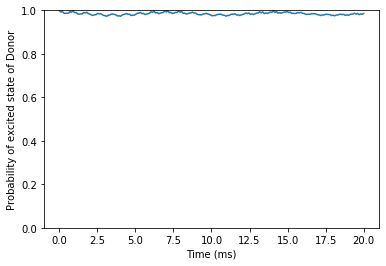

k =  2.5
time elapsed: 0:00:14.310394


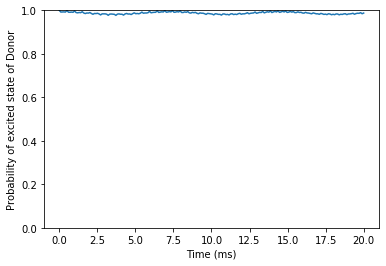

k =  2.75
time elapsed: 0:00:23.965719


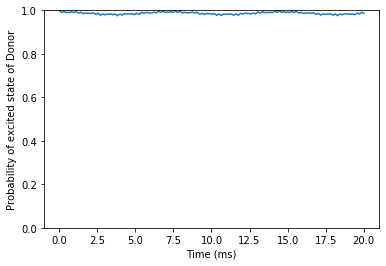

k =  3.0
time elapsed: 0:00:11.075708


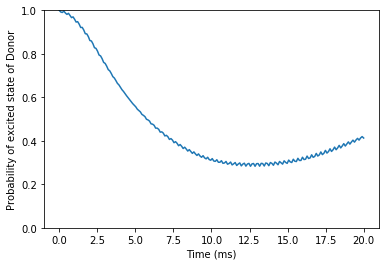

k =  3.25
time elapsed: 0:00:11.446542


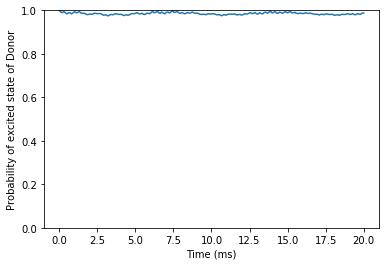

k =  3.5
time elapsed: 0:00:10.521134


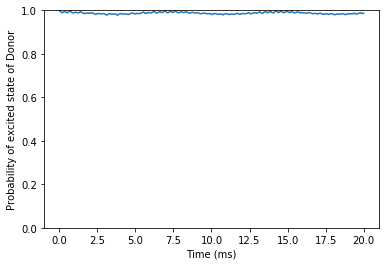

k =  3.75
time elapsed: 0:00:09.787282


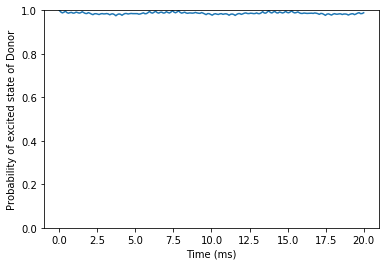

k =  4.0
time elapsed: 0:00:09.151616


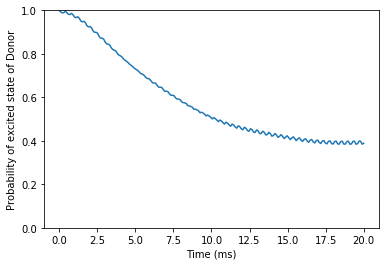

k =  4.25
time elapsed: 0:00:09.913858


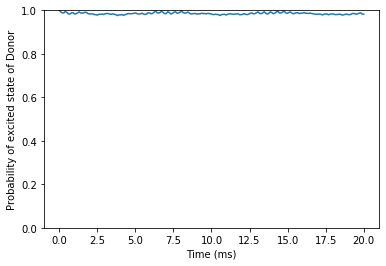

k =  4.5
time elapsed: 0:00:09.542631


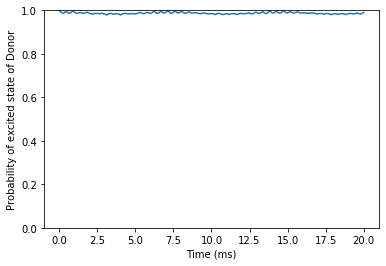

k =  4.750000000000001
time elapsed: 0:00:09.741317


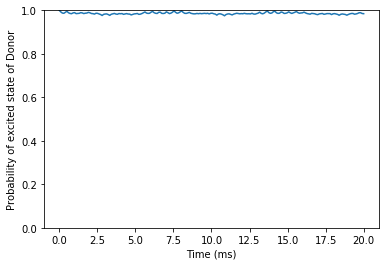

k =  5.0
time elapsed: 0:00:08.881438


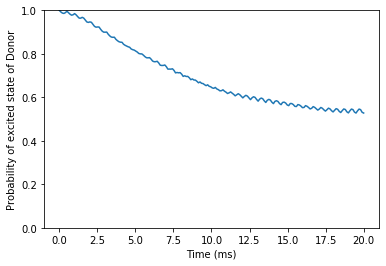

In [97]:
J = 1.3
Delta = 10
kappa = 1.4
NU = np.sqrt(J**2+Delta**2)
k = np.linspace(1, 5, 17)
nus = NU/k
for nu in nus:
    print('k = ',NU/nu)
    exp3 = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = -nu)
    exp3.time_scan(0, 20, 200, nth = 0.5)

k =  1.0
time elapsed: 0:00:01.422225


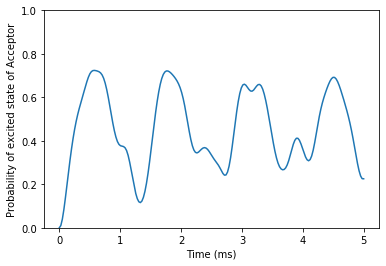

k =  1.25
time elapsed: 0:00:01.302961


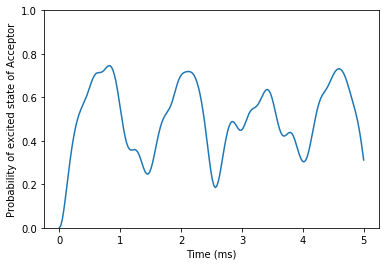

k =  1.5
time elapsed: 0:00:00.972889


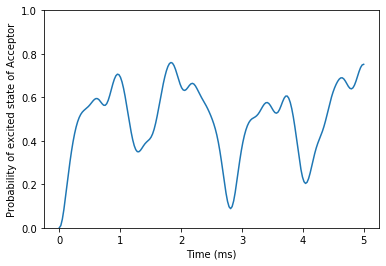

k =  1.75
time elapsed: 0:00:00.911954


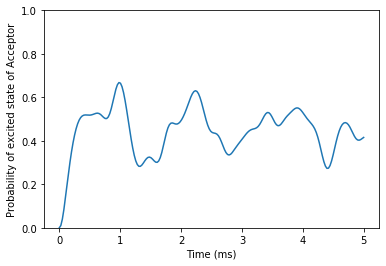

k =  2.0
time elapsed: 0:00:00.920566


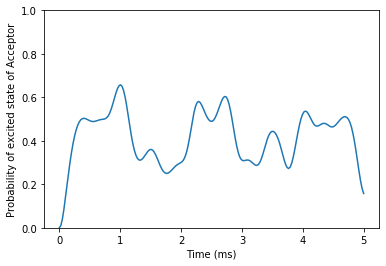

k =  2.25
time elapsed: 0:00:01.032202


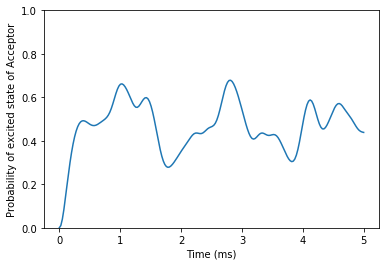

k =  2.5
time elapsed: 0:00:00.702128


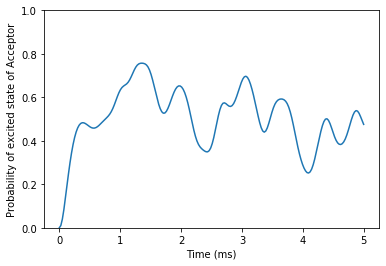

k =  2.75
time elapsed: 0:00:00.608551


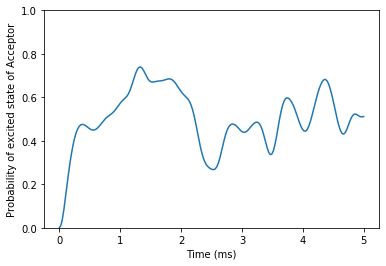

k =  3.0
time elapsed: 0:00:00.588975


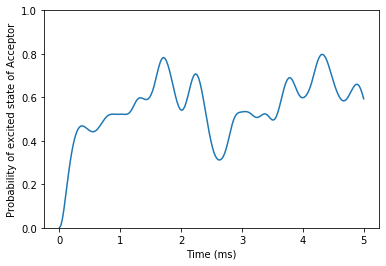

k =  3.2500000000000004
time elapsed: 0:00:00.691256


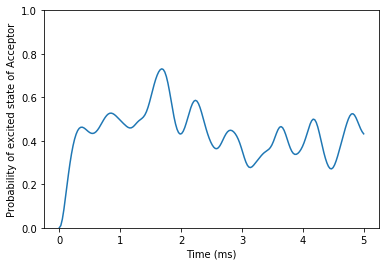

k =  3.5
time elapsed: 0:00:00.650904


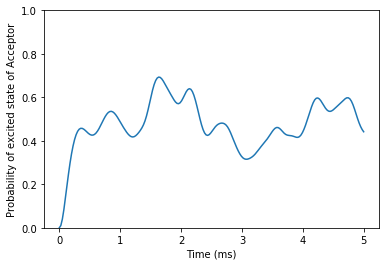

k =  3.75
time elapsed: 0:00:00.593816


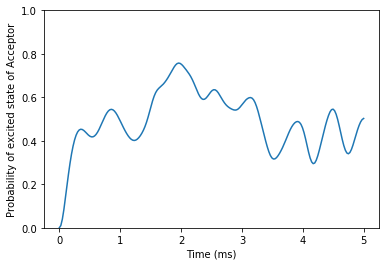

k =  4.0
time elapsed: 0:00:00.472668


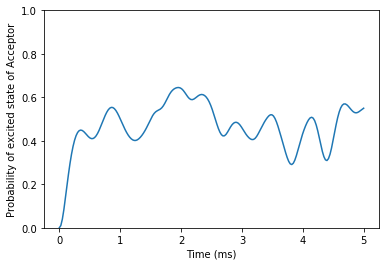

k =  4.25
time elapsed: 0:00:00.450478


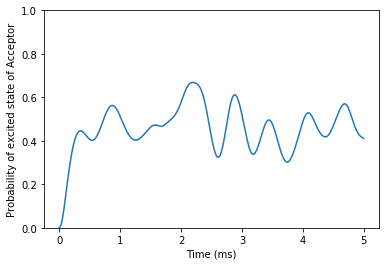

k =  4.5
time elapsed: 0:00:00.477025


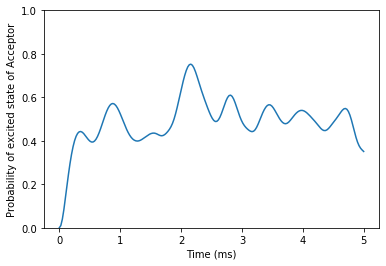

k =  4.75
time elapsed: 0:00:00.459494


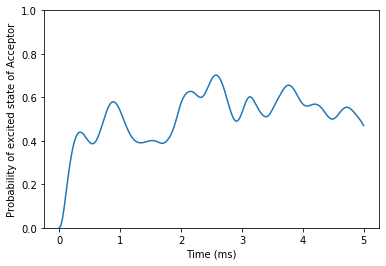

k =  5.0
time elapsed: 0:00:00.519592


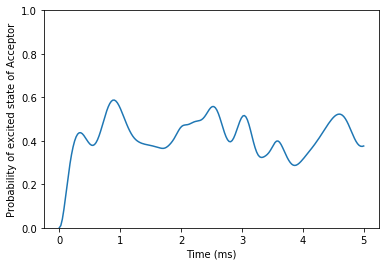

In [58]:
k = np.linspace(1, 5, 17)
J = 1.3
Delta = 1.3
kappa = 1.3
NU = np.sqrt(J**2+Delta**2)
nus = NU/k
for nu in nus:
    print('k = ',NU/nu)
    exp3 = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = -nu)
    exp3.time_scan(0, 5, 200, nth = 0.5, which = 1)

### Finding 2.
At high temperature (large $\bar{n}$), there is a symmtry between possitive and negetive $\nu_{eff}$. However, at low temperature (small $\bar{n}$), the result shows a suppression for possitive $\nu_{eff}$ but exhibits strong peaks at negative $\nu_{eff}$. This is similar to the suppression on the red sideband after cooling.
<br>
A negative $\nu_{eff}$ means negative detuning $\Delta$.

nth = 10 , nu =  4.741687463340451
time elapsed: 0:00:01.359211


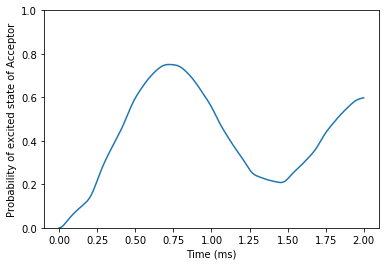

nth = 10 , nu =  -4.741687463340451
time elapsed: 0:00:01.423502


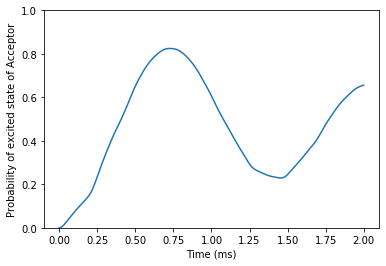

nth = 0.1 , nu =  4.741687463340451
time elapsed: 0:00:00.977811


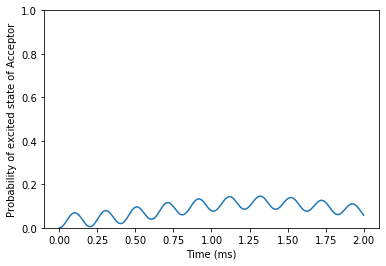

nth = 0.1 , nu =  -4.741687463340451
time elapsed: 0:00:01.157332


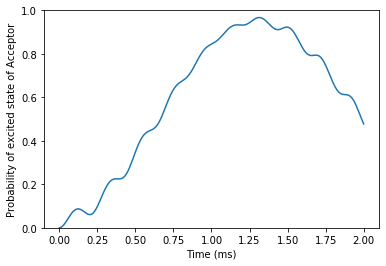

In [121]:
J = 1.3
Delta = 4.56
kappa = 1.4
nu = np.sqrt(J**2+Delta**2)
nth = 10
exp = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = nu)
print('nth =', nth, ', nu = ', nu)
exp.time_scan(0, 2, 200, nth = nth, which = 1)
exp = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = -nu)
print('nth =', nth, ', nu = ', -nu)
exp.time_scan(0, 2, 200, nth = nth, which = 1)

nth = 0.1
exp = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = nu)
print('nth =', nth, ', nu = ', nu)
exp.time_scan(0, 2, 200, nth = nth, which = 1)
exp = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = -nu)
print('nth =', nth, ', nu = ', -nu)
exp.time_scan(0, 2, 200, nth = nth, which = 1)

### Finding 3.
(a) Energy transfer speed will increase if the temperature become higher due to stronger fluctuations from the environment.
<br>
(b) At near ground state (very low temperature), we observe almost complete energy transfer. 

nth =  0.1
time elapsed: 0:00:01.515097


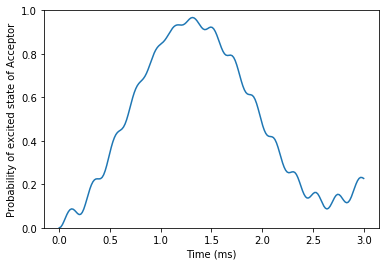

nth =  2.575
time elapsed: 0:00:02.340376


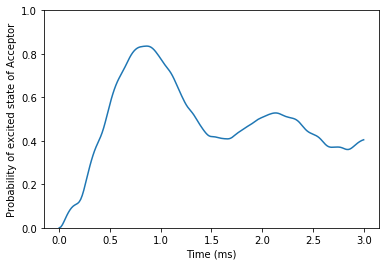

nth =  5.05
time elapsed: 0:00:02.948950


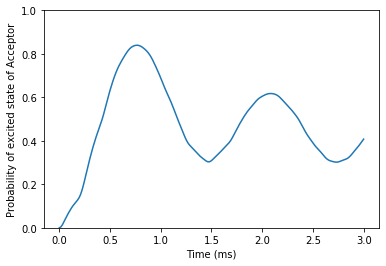

nth =  7.525
time elapsed: 0:00:02.887104


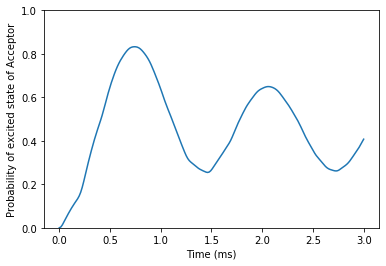

nth =  10.0
time elapsed: 0:00:02.825302


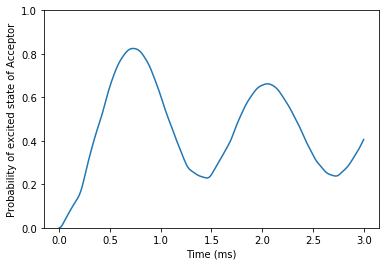

In [104]:
J = 1.3
Delta = 4.56
kappa = 1.4
nu = np.sqrt(J**2+Delta**2)
nths = np.linspace(0.1, 10, 5)
for nth in nths:
    print('nth = ',nth)
    exp3 = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = -nu)
    exp3.time_scan(0, 3, 200, nth = nth, which = 1)

### Scanning

J =  0.1
time elapsed: 0:00:00.751961


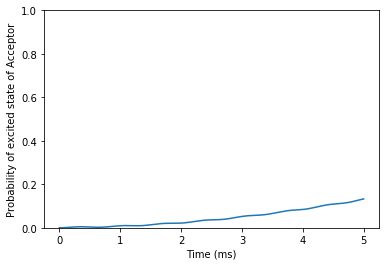

J =  1.09
time elapsed: 0:00:00.845577


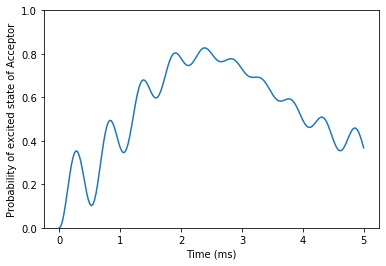

J =  2.08
time elapsed: 0:00:01.482403


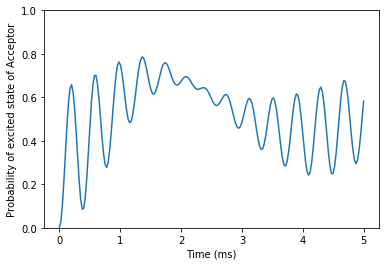

J =  3.07
time elapsed: 0:00:02.292093


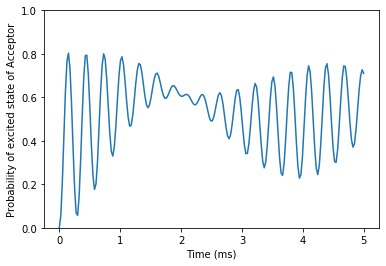

J =  4.06
time elapsed: 0:00:02.839628


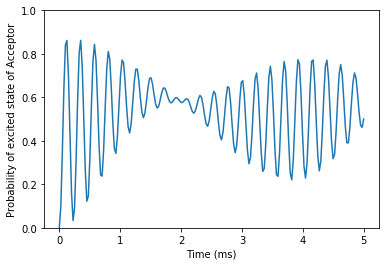

J =  5.05
time elapsed: 0:00:03.479311


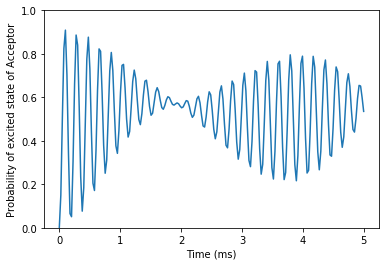

J =  6.039999999999999
time elapsed: 0:00:06.129721


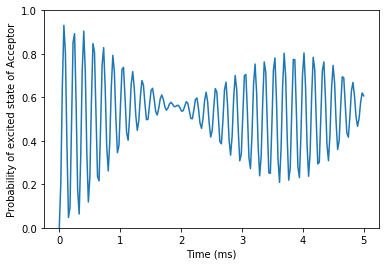

J =  7.029999999999999
time elapsed: 0:00:06.642476


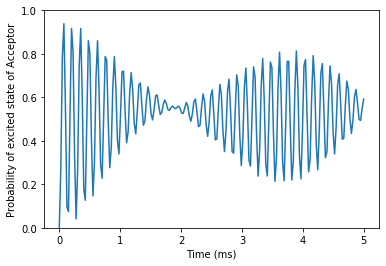

J =  8.02
time elapsed: 0:00:05.113715


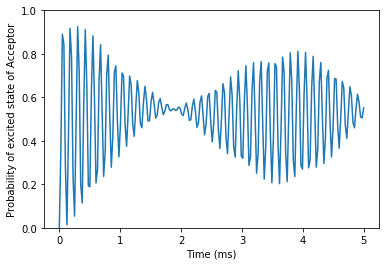

J =  9.01
time elapsed: 0:00:09.598879


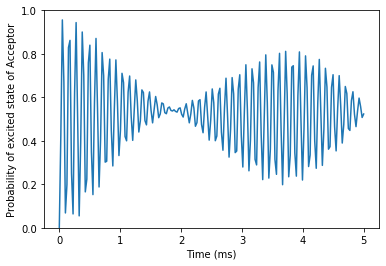

J =  10.0
time elapsed: 0:00:06.755118


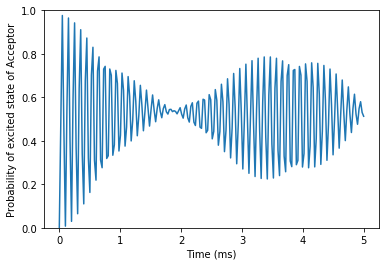

In [151]:
Js = np.linspace(0.1, 10, 11)
Delta = 1.5
for J in Js:
    print('J = ',J)
    nu = -np.sqrt(J**2+Delta**2)
    exp3 = VAET(Nmax=20, J = J, Delta = Delta, kappa = 0.3, nu = nu)
    exp3.time_scan(0, 5, 200, nth = 0.5, which = 1)

Delta =  0.1
time elapsed: 0:00:01.361648


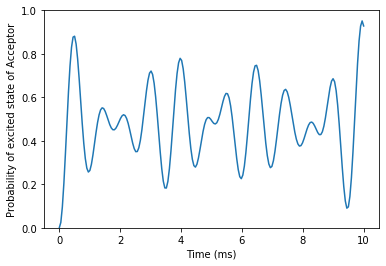

Delta =  0.595
time elapsed: 0:00:01.531635


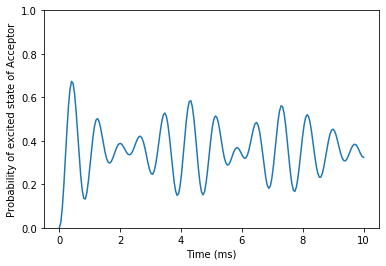

Delta =  1.09
time elapsed: 0:00:01.720527


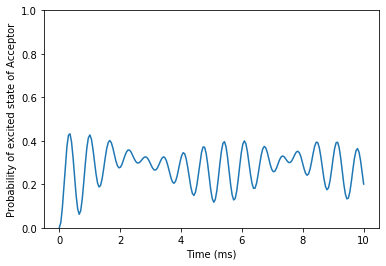

Delta =  1.585
time elapsed: 0:00:03.200827


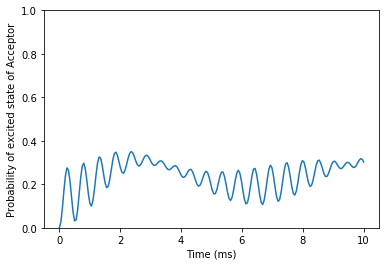

Delta =  2.08
time elapsed: 0:00:02.672861


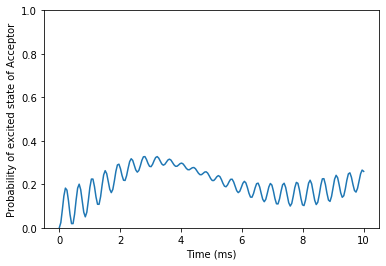

Delta =  2.575
time elapsed: 0:00:03.649557


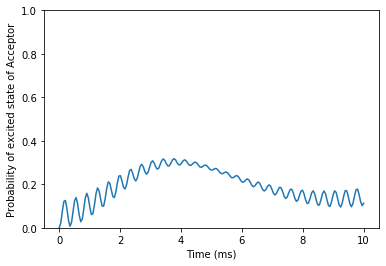

Delta =  3.07
time elapsed: 0:00:07.163859


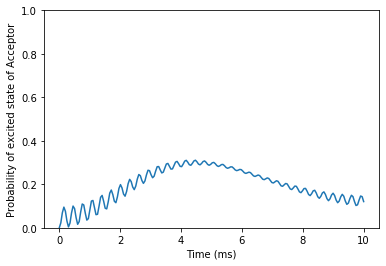

Delta =  3.565
time elapsed: 0:00:07.485096


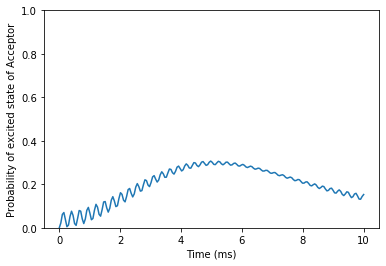

Delta =  4.06
time elapsed: 0:00:08.813398


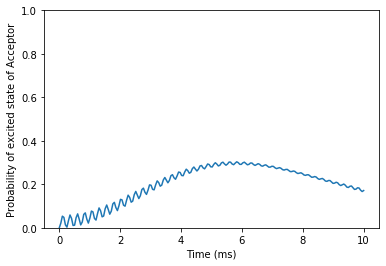

Delta =  4.555
time elapsed: 0:00:11.231853


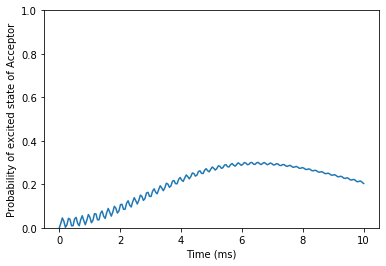

Delta =  5.05
time elapsed: 0:00:08.974545


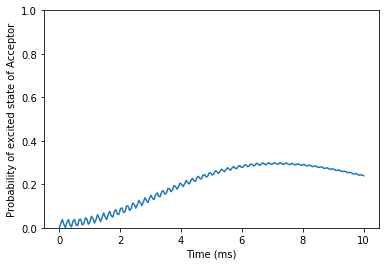

Delta =  5.545
time elapsed: 0:00:09.813810


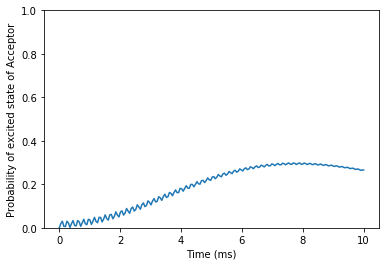

Delta =  6.039999999999999
time elapsed: 0:00:10.475549


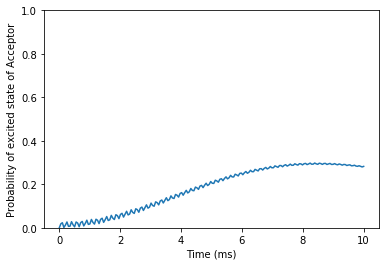

Delta =  6.534999999999999
time elapsed: 0:00:11.610427


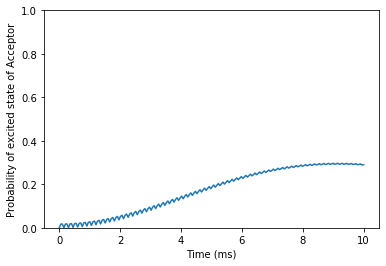

Delta =  7.029999999999999
time elapsed: 0:00:10.717568


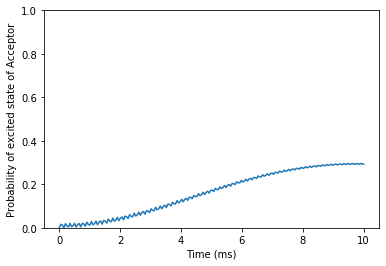

Delta =  7.5249999999999995
time elapsed: 0:00:13.658081


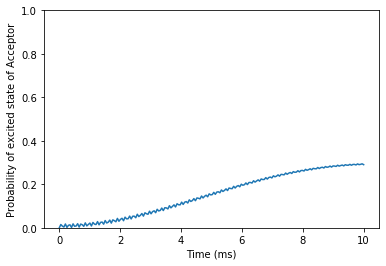

Delta =  8.02
time elapsed: 0:00:14.632003


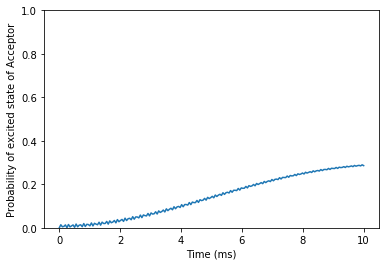

Delta =  8.514999999999999
time elapsed: 0:00:26.169114


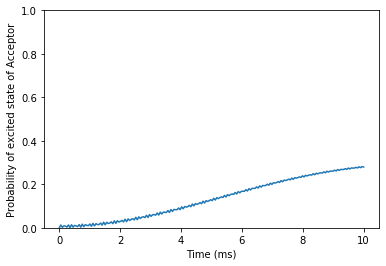

Delta =  9.01
time elapsed: 0:00:17.828138


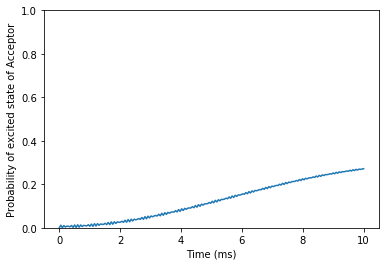

Delta =  9.504999999999999
time elapsed: 0:00:30.032441


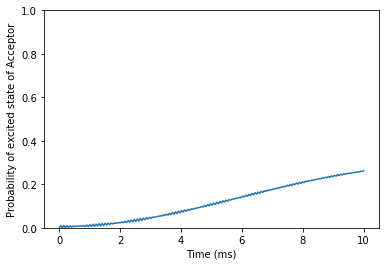

Delta =  10.0
time elapsed: 0:00:19.938283


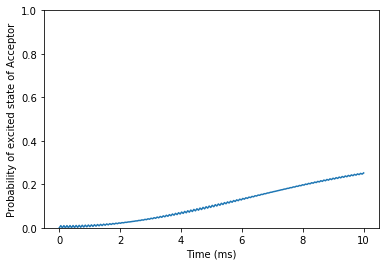

In [30]:
Deltas = np.linspace(0.1, 10, 21)
J = 1
for Delta in Deltas:
    print('Delta = ',Delta)
    nu = -np.sqrt(J**2+Delta**2)
    exp3 = VAET(Nmax=20, J = J, Delta = Delta, kappa = 0.3, nu = nu)
    exp3.time_scan(0, 10, 200, nth = 0.5, which = 1)

kappa =  0.1
time elapsed: 0:00:01.407224


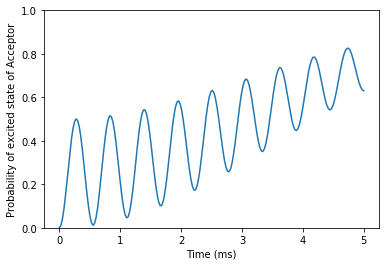

kappa =  0.2
time elapsed: 0:00:01.148811


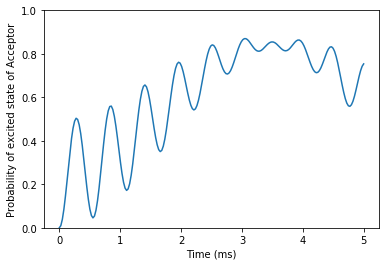

kappa =  0.3
time elapsed: 0:00:00.869345


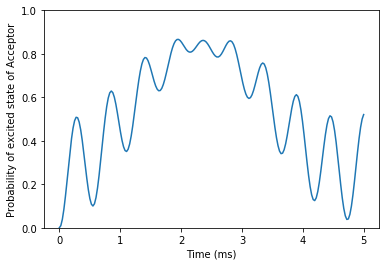

kappa =  0.4
time elapsed: 0:00:00.912203


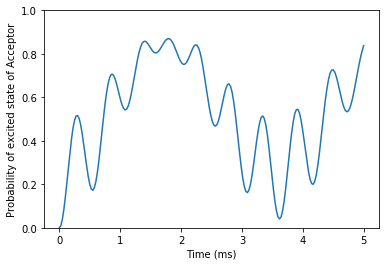

kappa =  0.5
time elapsed: 0:00:01.135220


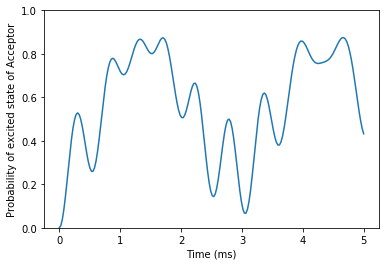

kappa =  0.6
time elapsed: 0:00:01.212244


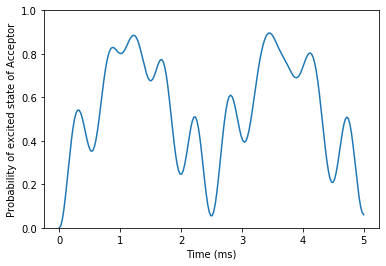

kappa =  0.7
time elapsed: 0:00:01.349787


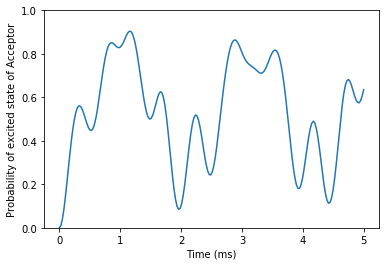

kappa =  0.7999999999999999
time elapsed: 0:00:01.334456


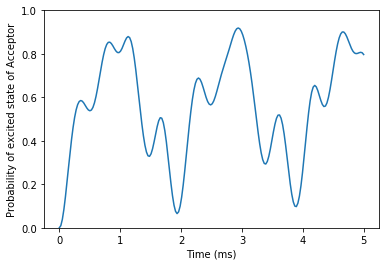

kappa =  0.8999999999999999
time elapsed: 0:00:01.240746


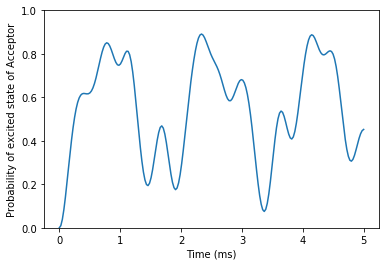

kappa =  0.9999999999999999
time elapsed: 0:00:01.293647


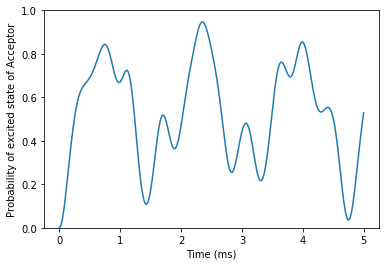

kappa =  1.0999999999999999
time elapsed: 0:00:01.364798


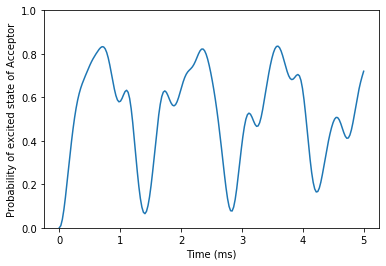

kappa =  1.2
time elapsed: 0:00:01.481416


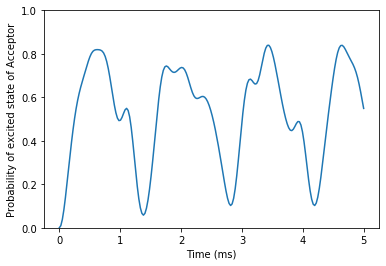

kappa =  1.3
time elapsed: 0:00:01.462893


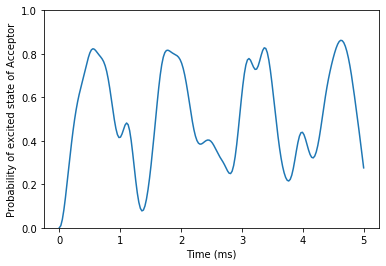

kappa =  1.4
time elapsed: 0:00:01.453898


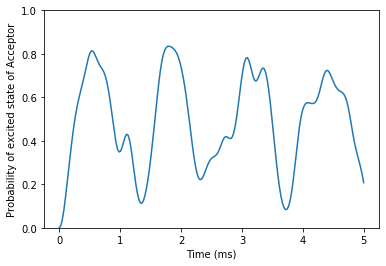

kappa =  1.5
time elapsed: 0:00:01.324996


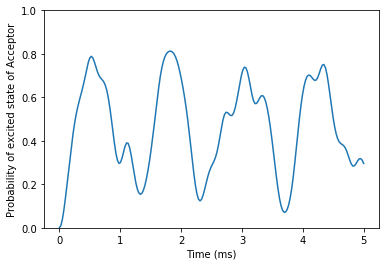

kappa =  1.5999999999999999
time elapsed: 0:00:01.336081


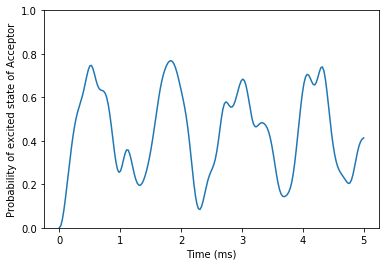

kappa =  1.7
time elapsed: 0:00:01.412001


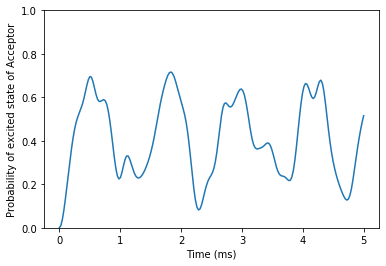

kappa =  1.8
time elapsed: 0:00:01.376572


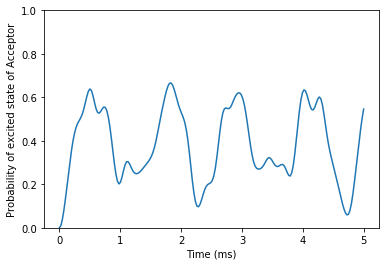

kappa =  1.9
time elapsed: 0:00:01.505215


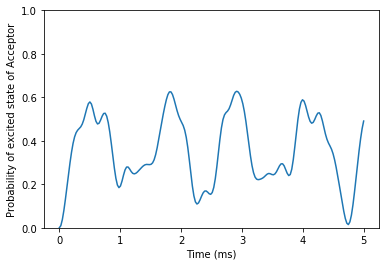

kappa =  2.0
time elapsed: 0:00:01.311915


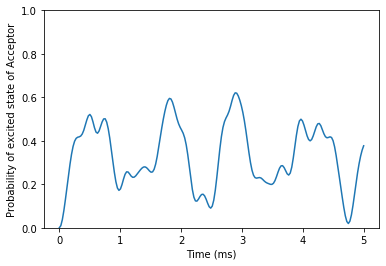

kappa =  2.0999999999999996
time elapsed: 0:00:01.373607


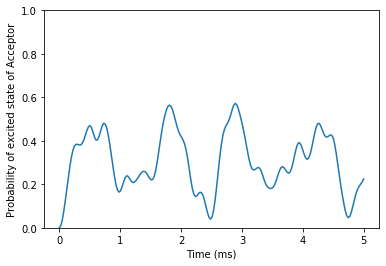

kappa =  2.1999999999999997
time elapsed: 0:00:01.378596


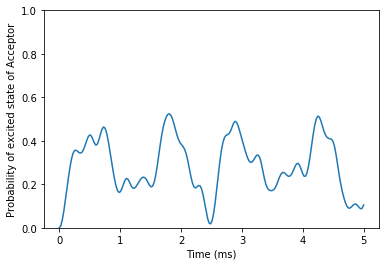

kappa =  2.3
time elapsed: 0:00:01.476968


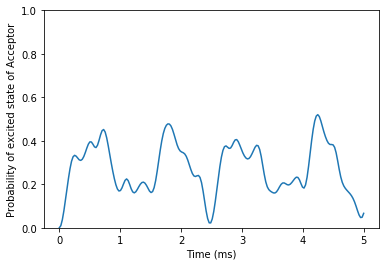

kappa =  2.4
time elapsed: 0:00:01.504817


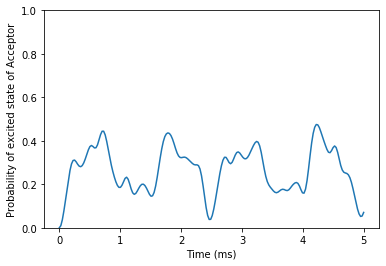

kappa =  2.5
time elapsed: 0:00:01.483019


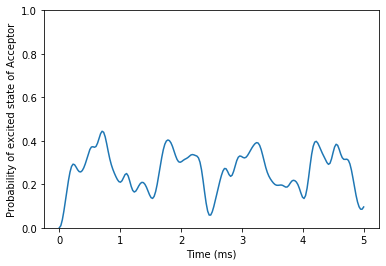

kappa =  2.6
time elapsed: 0:00:01.549511


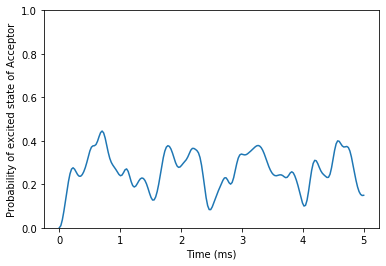

kappa =  2.6999999999999997
time elapsed: 0:00:01.621959


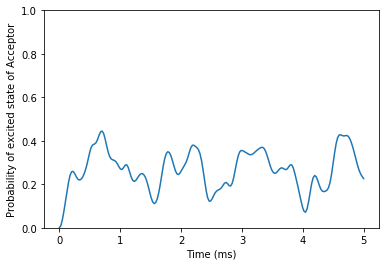

kappa =  2.8
time elapsed: 0:00:01.569042


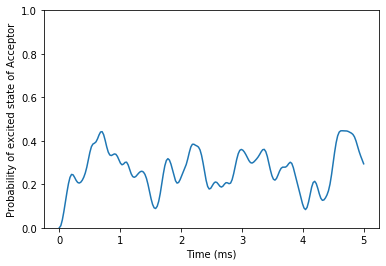

kappa =  2.9
time elapsed: 0:00:01.768297


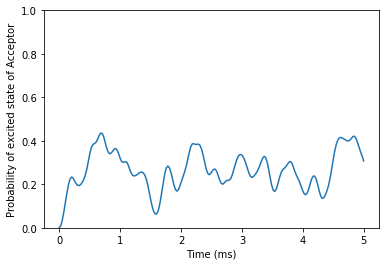

kappa =  3.0
time elapsed: 0:00:01.806728


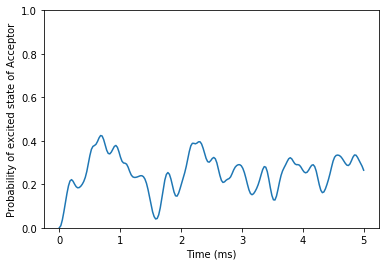

In [80]:
kappas = np.linspace(0.1, 3, 30)
J = 1.27
Delta = 1.27
nu = np.sqrt(J**2+Delta**2)
for kappa in kappas:
    print('kappa = ',kappa)
    exp3 = VAET(Nmax=20, J = J, Delta = Delta, kappa = kappa, nu = nu)
    exp3.time_scan(0, 5, 200, nth = 0.04, which = 1)

time elapsed: 0:04:17.068042


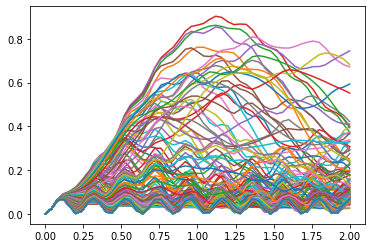

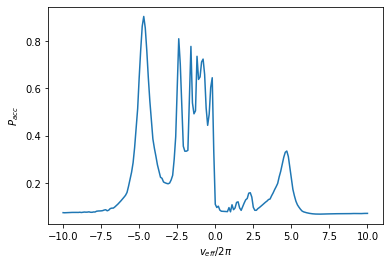

In [116]:
exp = VAET(Nmax=20, J = 1.3, Delta = 4.56, kappa = 1.4)
NU = np.sqrt(J**2+Delta**2)
exp.ScanPaccVsVeff(Navg = 1,
                       noise = 0,
                       nu_start = -10,
                       nu_stop = 10,
                       Nusample = 201,
                       t_start = 0,
                       t_stop = 2,
                       Nsample = 51,
                       Delta = 4.56,
                       nth = 0.5)

time elapsed: 0:05:48.631333


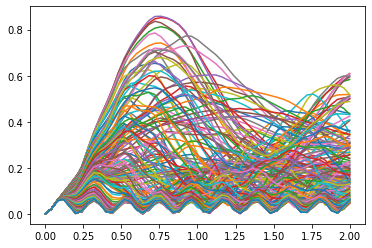

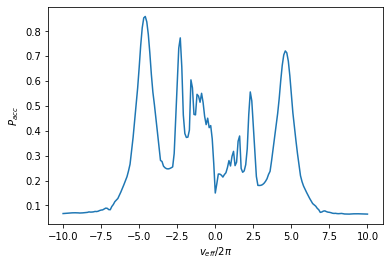

In [117]:
exp = VAET(Nmax=20, J = 1.3, Delta = 4.56, kappa = 1.4)
exp.ScanPaccVsVeff(Navg = 1,
                       noise = 0,
                       nu_start = -10,
                       nu_stop = 10,
                       Nusample = 201,
                       t_start = 0,
                       t_stop = 2,
                       Nsample = 51,
                       Delta = 4.56,
                       nth = 5)